# Computer Vision - OCR Parsing example

###### Links: [Apple Financial Statement (2021)](https://s2.q4cdn.com/470004039/files/doc_financials/2021/q4/_10-K-2021-(As-Filed).pdf)  |  [Article (TowardsDataScience)](https://towardsdatascience.com/document-parsing-with-python-ocr-75543448e581)

### 0 - Setup

###### Import pckgs

In [2]:
import warnings
warnings.filterwarnings("ignore")

## for data
import os
import io
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt

## for ocr
import pdf2image
import cv2
import layoutparser as lp

In [2]:
# if use pytesserect, specify file.exe path for Windows
#import pytesseract
#import platform
#if platform.system() == "Windows":
#    pytesseract.pytesseract.tesseract_cmd = "c:/profili/Downloads/my/OCR/tesseract.exe"

###### Import data

In [4]:
i = 21

In [3]:
#As Text
from PyPDF2 import PdfReader

doc = PdfReader("doc_apple.pdf")
len(doc.pages)

82

In [4]:
print(doc.pages[i].extract_text())

Company Stock Performance
The following graph shows a comparison of cumulative total shareholder return, calculated on a dividend-reinvested basis, for 
the Company, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector 
Index for the five years ended September 25, 2021. The graph assumes $100 was invested in each of the Company’s common 
stock, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector Index as of 
the market close on September 23, 2016. Note that past stock price performance is not necessarily indicative of future stock 
price performance.
COMPARISON OF 5-YEAR CUMULATIVE TOTAL RETURN*Among Apple Inc., the S&P 500 Index, the S&P Information Technology Indexand the Dow Jones U.S. Technology Supersector IndexApple Inc.S&P 500 IndexS&P Information Technology IndexDow Jones U.S. Technology Supersector Index9/23/169/30/179/29/189/28/199/26/209/25/21$0$100$200$300$400$500$600
*$100 in

In [3]:
# As Image
doc = pdf2image.convert_from_path("doc_apple.pdf", dpi=300)
len(doc)

82

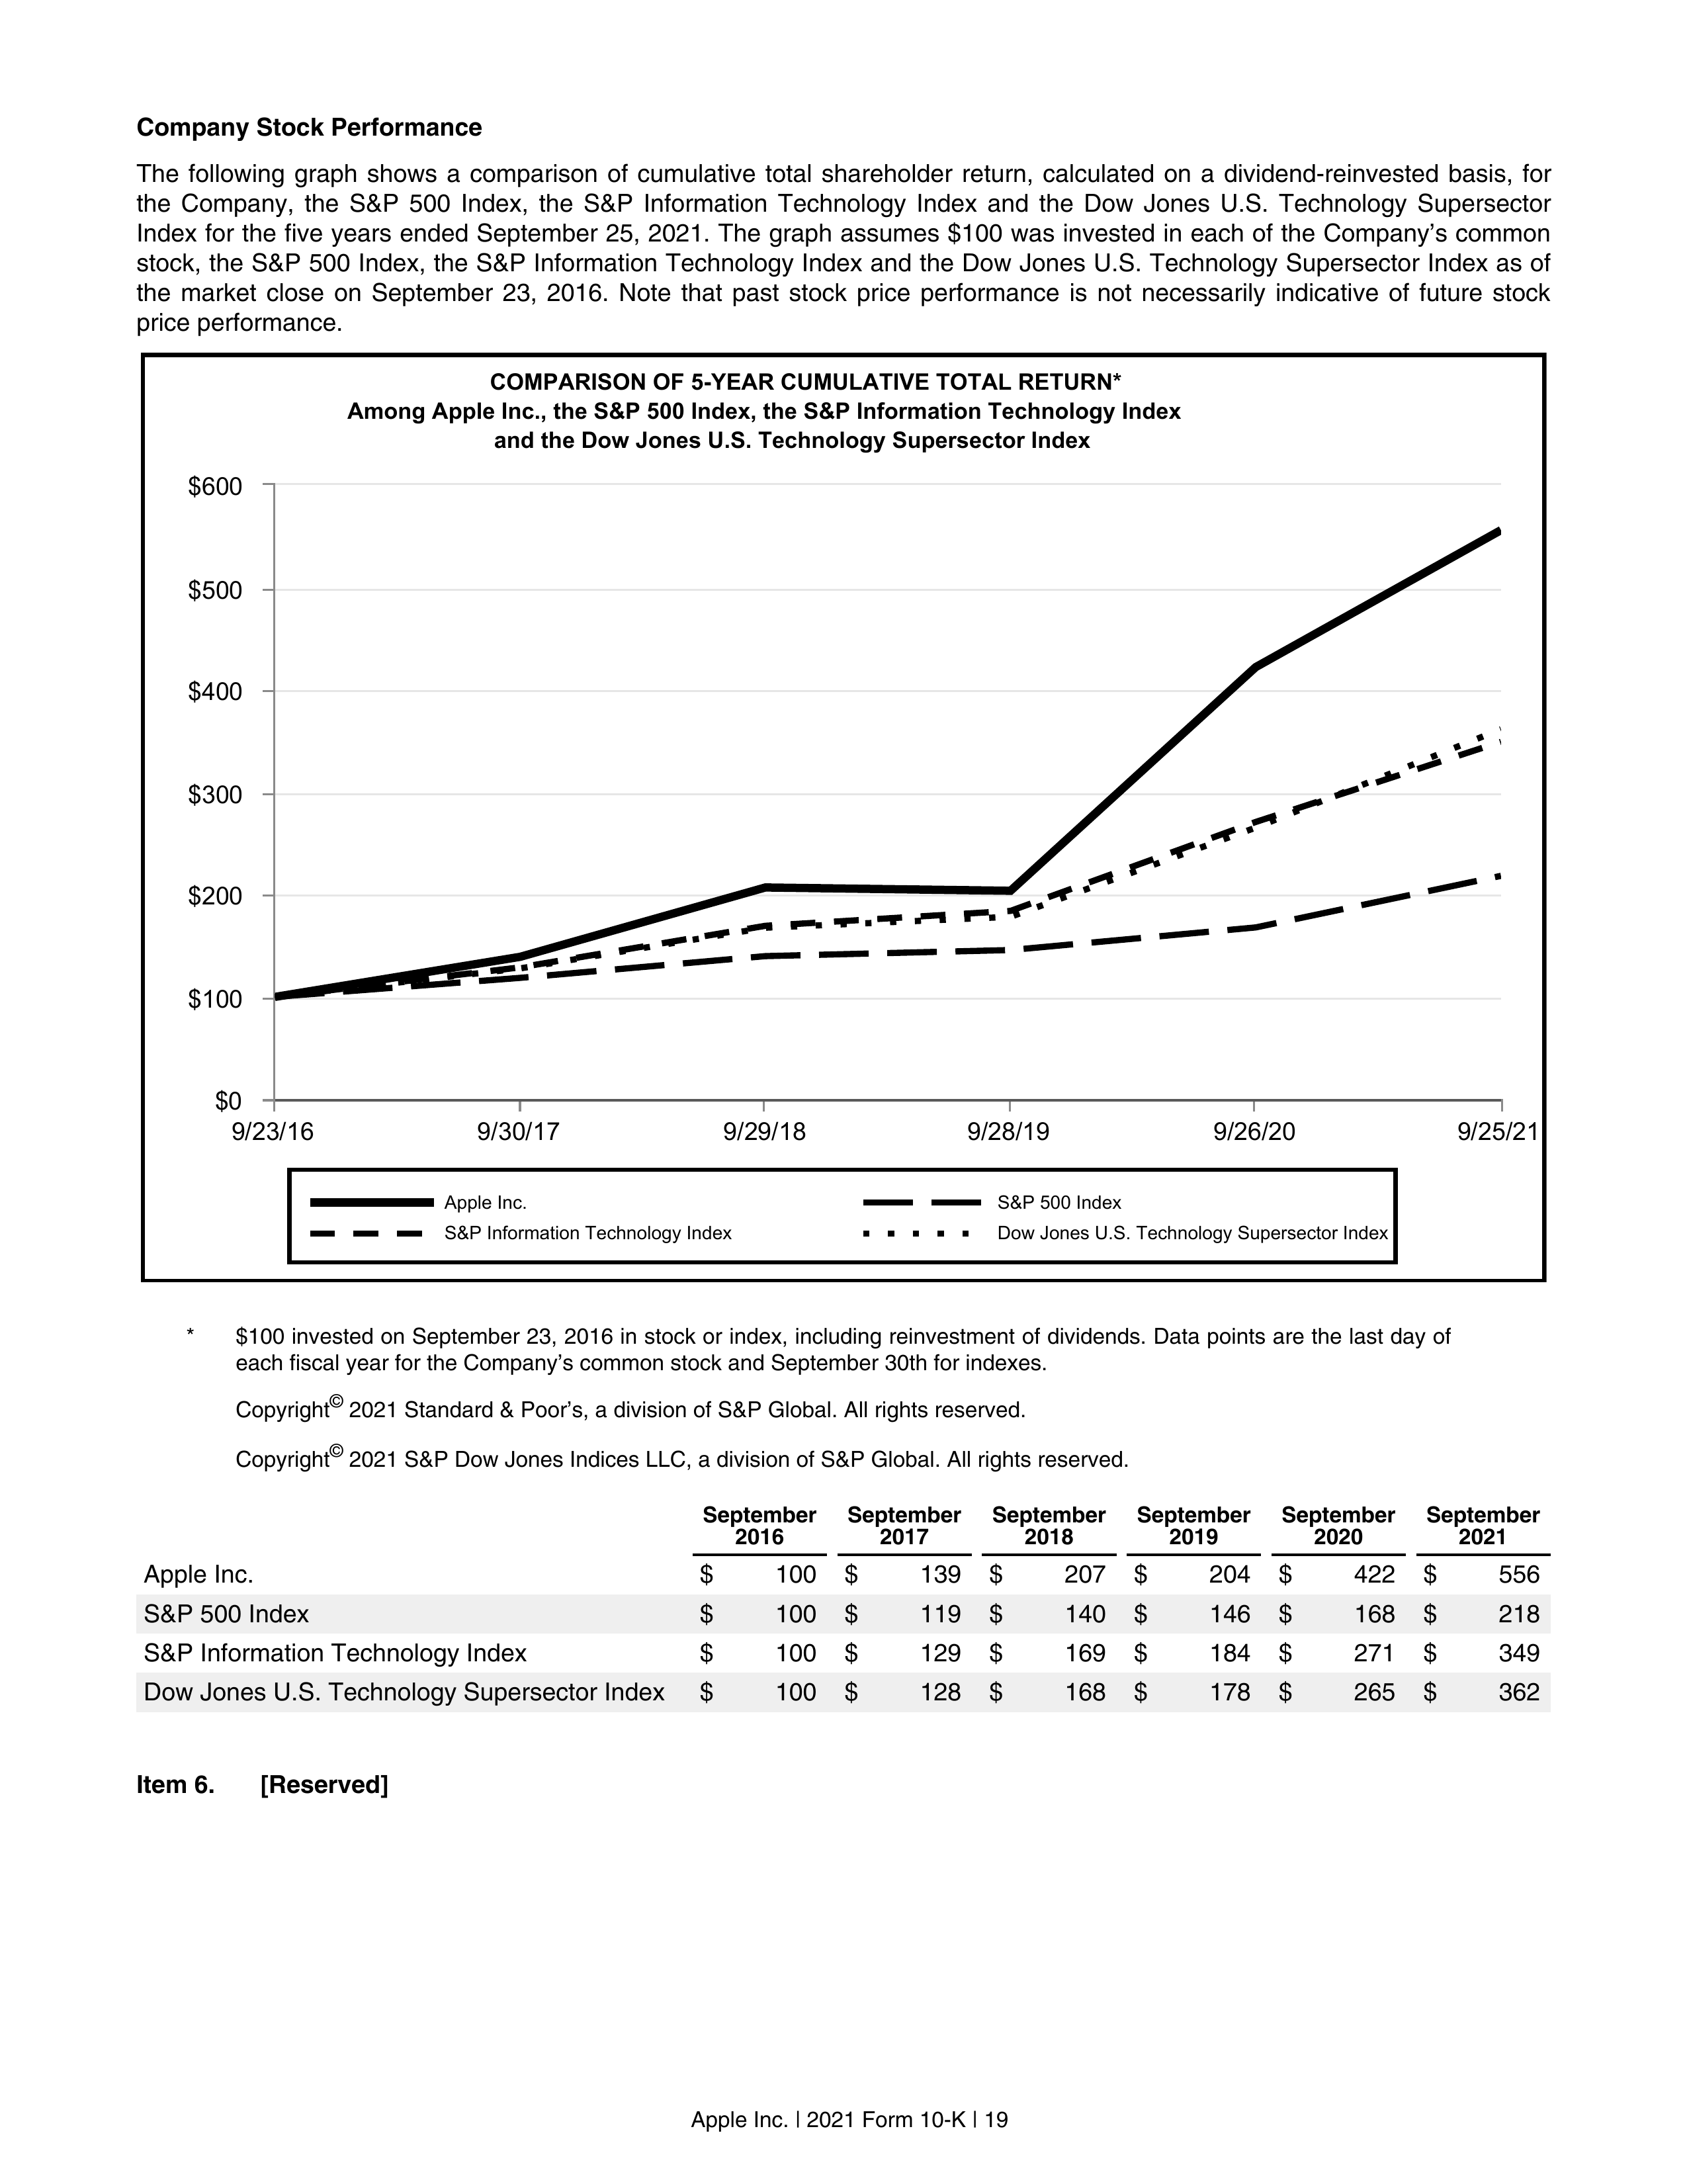

In [6]:
doc[i]

In [7]:
# Save imgs
folder = "doc"
if folder not in os.listdir():
    os.makedirs(folder)

p = 1
for page in doc:
    image_name = "page_"+str(p)+".jpg"  
    page.save(os.path.join(folder, image_name), "JPEG")
    p = p+1

### 1 - Detection

###### Model

In [22]:
# General
model = lp.Detectron2LayoutModel("lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config",
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0:"Text", 1:"Title", 2:"List", 3:"Table", 4:"Figure"})

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


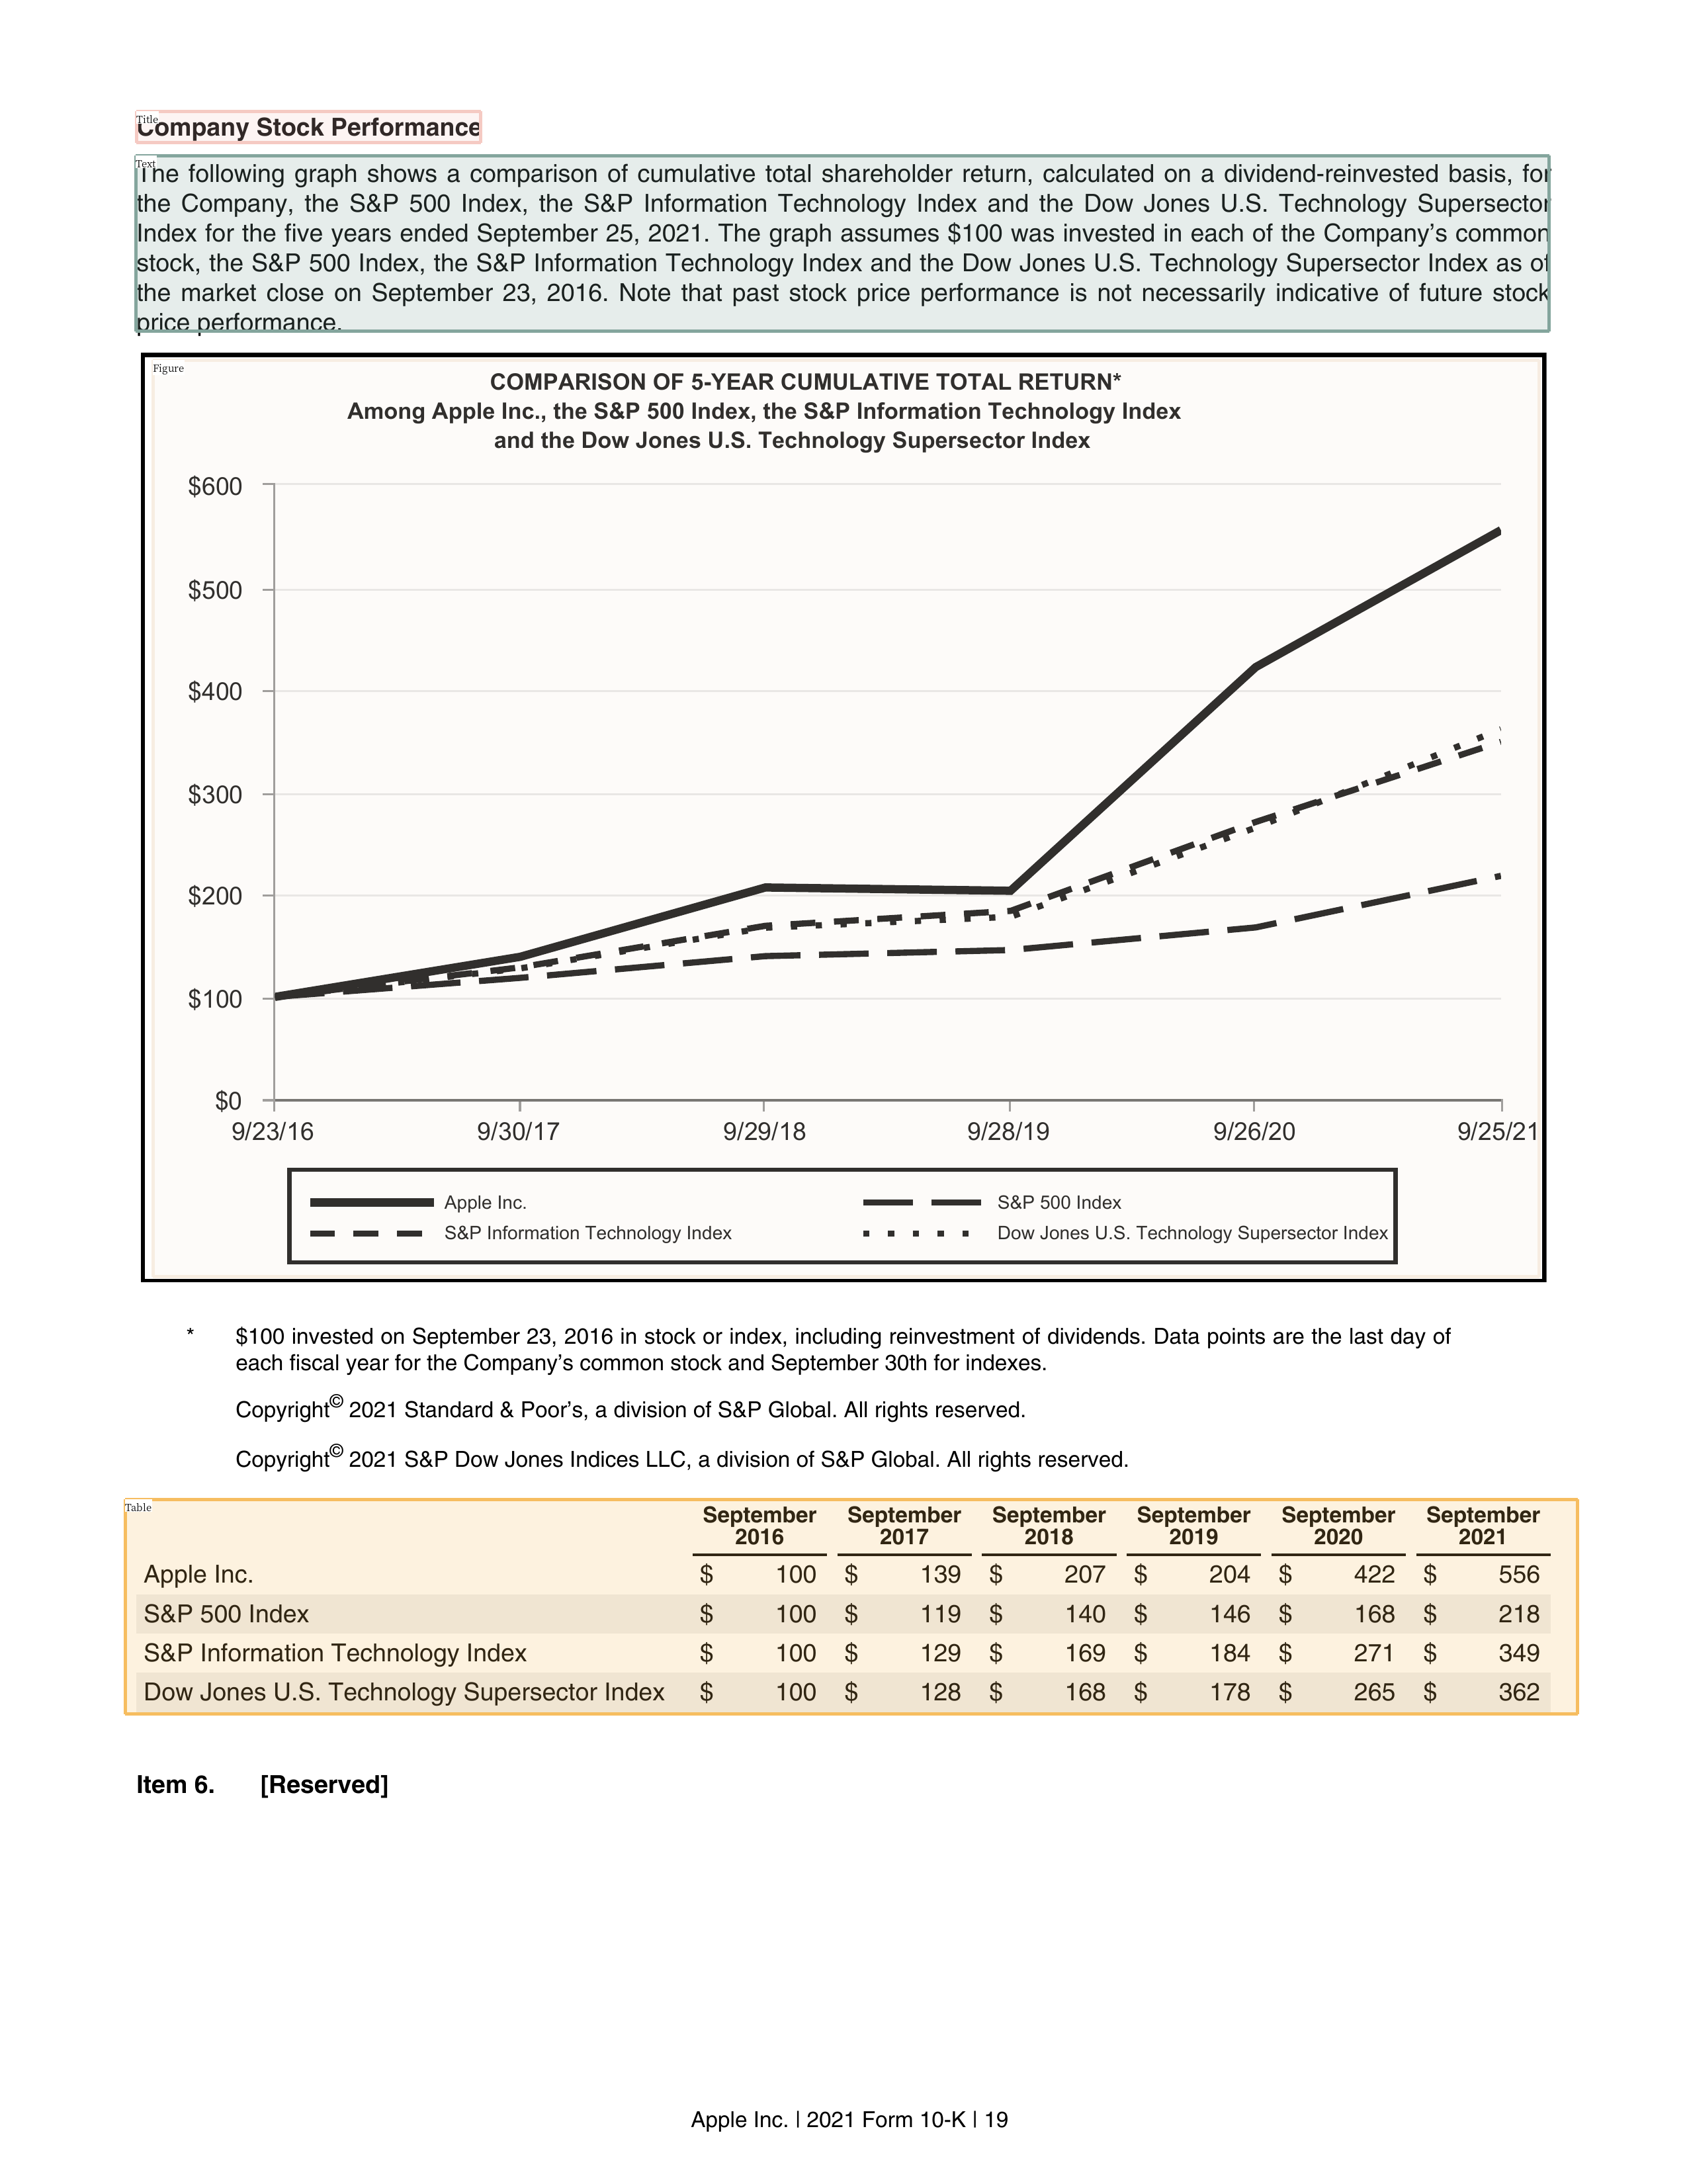

In [9]:
## turn img into array
img = np.asarray(doc[i])

## predict
detected = model.detect(img)

## plot
lp.draw_box(img, detected, box_width=5, box_alpha=0.2, show_element_type=True)

###### Sorting

In [8]:
# sort detected
def split_page(img, n, axis):
    new_detected, start = [], 0
    for s in range(n):
        end = len(img[0])/3 * s if axis == "x" else len(img[1])/3
        section = lp.Interval(start=start, end=end, axis=axis).put_on_canvas(img)
        filter_detected = detected.filter_by(section, center=True)._blocks
        new_detected = new_detected + filter_detected
        start = end
    return lp.Layout([block.set(id=idx) for idx,block in enumerate(new_detected)])

In [9]:
n_cols,n_rows = 1,1

## if single page just sort based on y
if (n_cols == 1) and (n_rows == 1):
    new_detected = detected.sort(key=lambda x: x.coordinates[1])
    detected = lp.Layout([block.set(id=idx) for idx,block in enumerate(new_detected)])
    
## if multi columns sort by x,y
elif (n_cols > 1) and (n_rows == 1):
    detected = split_page(img, n_cols, axis="x")

## if multi rows sort by y,x
elif (n_cols > 1) and (n_rows == 1):
    detected = split_page(img, n_rows, axis="y")
    
## if multi columns-rows
else:
    pass

In [12]:
## check
for block in detected:
    print("---", str(block.id)+":", block.type, "---")
    print(block, end='\n\n')

--- 0: Title ---
TextBlock(block=Rectangle(x_1=206.8702392578125, y_1=168.66432189941406, x_2=726.1875, y_2=215.66148376464844), text=None, id=0, type=Title, parent=None, next=None, score=0.8002211451530457)

--- 1: Text ---
TextBlock(block=Rectangle(x_1=205.97486877441406, y_1=235.43258666992188, x_2=2341.459716796875, y_2=500.7732849121094), text=None, id=1, type=Text, parent=None, next=None, score=0.9956046342849731)

--- 2: Figure ---
TextBlock(block=Rectangle(x_1=231.3071746826172, y_1=544.8707885742188, x_2=2326.831787109375, y_2=1929.7564697265625), text=None, id=2, type=Figure, parent=None, next=None, score=0.983069896697998)

--- 3: Table ---
TextBlock(block=Rectangle(x_1=189.14195251464844, y_1=2266.2373046875, x_2=2384.693115234375, y_2=2590.511962890625), text=None, id=3, type=Table, parent=None, next=None, score=0.9510892629623413)



### 2 - Extraction

###### Model

In [12]:
model = lp.TesseractAgent(languages='eng')

In [10]:
dic_predicted = {}

In [20]:
'''
{'0-Title': '...',
 '1-Text':  '...', 
 '2-Figure': array([[ [0,0,0], ...]]),
 '3-Table': pd.DataFrame,
}
'''
def parse_doc(dic):
    for k,v in dic.items():
        if "Title" in k:
            print('\x1b[1;31m'+ v +'\x1b[0m')
        elif "Figure" in k:
            plt.figure(figsize=(10,5))
            plt.imshow(v)
            plt.show()
        else:
            print(v)
        print(" ")

###### Text

In [13]:
for block in [block for block in detected if block.type in ["Title","Text"]]:
    ## segmentation
    segmented = block.pad(left=15, right=15, top=5, bottom=5).crop_image(img)
    ## extraction
    extracted = model.detect(segmented)
    ## save
    dic_predicted[str(block.id)+"-"+block.type] = extracted.replace('\n',' ').strip()

dic_predicted

{'0-Title': 'Company Stock Performance',
 '1-Text': 'The following graph shows a comparison of cumulative total shareholder return, calculated on a dividend-reinvested basis, for the Company, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector Index for the five years ended September 25, 2021. The graph assumes $100 was invested in each of the Company’s common stock, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector Index as of the market close on September 23, 2016. Note that past stock price performance is not necessarily indicative of future stock price performance.'}

In [14]:
# check
parse_doc(dic_predicted)

Company Stock Performance
The following graph shows a comparison of cumulative total shareholder return, calculated on a dividend-reinvested basis, for the Company, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector Index for the five years ended September 25, 2021. The graph assumes $100 was invested in each of the Company’s common stock, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector Index as of the market close on September 23, 2016. Note that past stock price performance is not necessarily indicative of future stock price performance.


###### Figures

In [15]:
for block in [block for block in detected if block.type == "Figure"]:
    ## segmentation
    segmented = block.pad(left=15, right=15, top=5, bottom=5).crop_image(img)
    ## save
    dic_predicted[str(block.id)+"-"+block.type] = segmented

Company Stock Performance
The following graph shows a comparison of cumulative total shareholder return, calculated on a dividend-reinvested basis, for the Company, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector Index for the five years ended September 25, 2021. The graph assumes $100 was invested in each of the Company’s common stock, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector Index as of the market close on September 23, 2016. Note that past stock price performance is not necessarily indicative of future stock price performance.


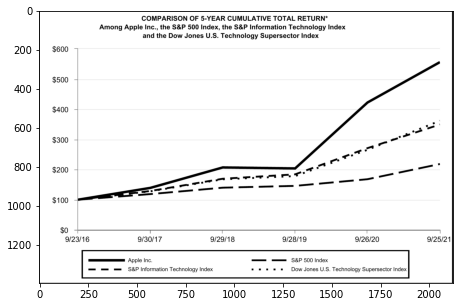

In [16]:
# check
parse_doc(dic_predicted)

###### Tables

In [18]:
for block in [block for block in detected if block.type == "Table"]:
    ## segmentation
    segmented = block.pad(left=15, right=15, top=5, bottom=5).crop_image(img)
    ## extraction
    extracted = model.detect(segmented)
    ## save
    dic_predicted[str(block.id)+"-"+block.type] = pd.read_csv( io.StringIO(extracted) )

Company Stock Performance
 
The following graph shows a comparison of cumulative total shareholder return, calculated on a dividend-reinvested basis, for the Company, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector Index for the five years ended September 25, 2021. The graph assumes $100 was invested in each of the Company’s common stock, the S&P 500 Index, the S&P Information Technology Index and the Dow Jones U.S. Technology Supersector Index as of the market close on September 23, 2016. Note that past stock price performance is not necessarily indicative of future stock price performance.
 


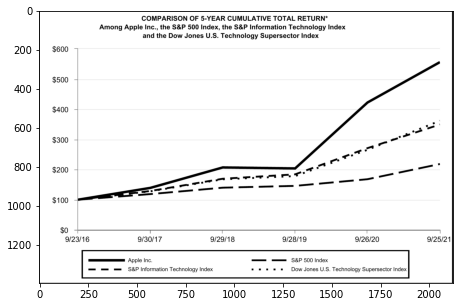

 
  September September September September September September
0                      2016 2017 2018 2019 2020 2021         
1     Apple Inc. $ 100 $ 139 $ 207 $ 204 $ 422 $ 556         
2  S&P 500 Index $ 100 $ 119 $ 140 $ 146 $ 168 $ 218         
3  S&P Information Technology Index $ 100 $ 129 $...         
4  Dow Jones U.S. Technology Supersector Index $ ...         
 


In [21]:
# check
parse_doc(dic_predicted)

In [3]:
# without OCR
import tabula

tables = tabula.read_pdf("doc_apple.pdf", pages=i+1)
tables[0]

,Unnamed: 0,September,September.1,September.2,September.3,September.4,September.5
0,NaN,2016,2017,2018,2019,2020,2021
1,Apple Inc.,$ 100,$ 139,$ 207,$ 204,$ 422,$ 556
2,S&P 500 Index,$ 100,$ 119,$ 140,$ 146,$ 168,$ 218
3,S&P Information Technology Index,$ 100,$ 129,$ 169,$ 184,$ 271,$ 349
4,Dow Jones U.S. Technology Supersector Index,$ 100,$ 128,$ 168,$ 178,$ 265,$ 362
